In [1]:
using Agents
using DynamicalSystems
using InteractiveDynamics
using CairoMakie
using Plots
using StatsPlots

using Random
using Distributions
using Colors
using ColorSchemes
using Measures
using StatsBase
using PyCall
using Statistics

In [2]:
seed = 123

123

In [3]:
const NN = 30
const GRID_DIM = (NN,NN)
TOTAL_AGENTS = round( Int, 0.25*prod(GRID_DIM) );

In [4]:
function Mix(x, d1,d2) 
    return pdf(d1, x) + pdf(d2,x)
end

Mix (generic function with 1 method)

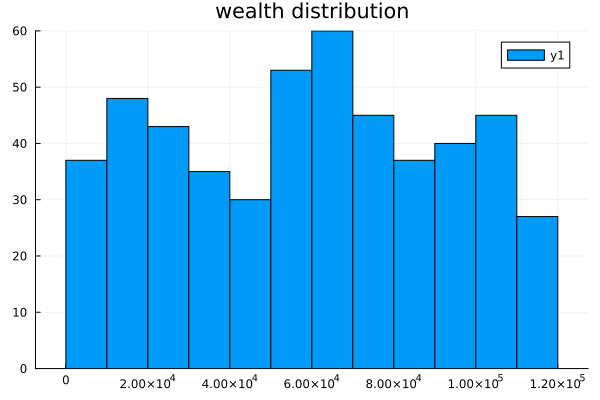

In [5]:

MEAN_MONEY = 60_000
SD_MONEY = 5_000;
SHAPE_PARAMETER_XI = 0.5
MONEY_DISTRIBUTION = Uniform( 1, 2*MEAN_MONEY ) # GeneralizedPareto(MEAN_MONEY, SD_MONEY, SHAPE_PARAMETER_XI) 

d1 = GeneralizedPareto(MEAN_MONEY, SD_MONEY, SHAPE_PARAMETER_XI) 
d2 = Gamma(MEAN_MONEY,0.5)

#println(Mix(60_000,d1,d2))

data = [ rand(MONEY_DISTRIBUTION,1)[1] for _ in 1:500 ]
Plots.histogram( data, bins=12, title="wealth distribution" )

In [6]:
AGENTS_MONEY = rand(MONEY_DISTRIBUTION, TOTAL_AGENTS)
MAX_MONEY = maximum( AGENTS_MONEY );
MOVEMENT_ENERGY_MIN_REQUIREMENT = 0.2

KineticEnergy(money) = 2 * money / MAX_MONEY

InvKineticEnergy(kinetic_energy) = (1/2) * MAX_MONEY * kinetic_energy #returns the money and money is then effectively the energy

PotentialEnergy(remain) = 1 * Int( !remain )

PotentialEnergy (generic function with 1 method)

In [7]:
FIXED_ENERGY_BINS = 0:0.2:1_000;

In [8]:
model_iteration = 0;

In [9]:
@agent SchellingAgent GridAgent{2} begin
    remain::Bool # whether the agent is happy to remain in its position. (true = remain, false = !remain)
    group::Int # The group of the agent, determines remain as it interacts with neighbors
    money::Float64 # how much money the agent has
    
    potential_energy::Int #identity
    kinetic_energy::Float64 #money as it is dissipated
    
end

In [10]:
function initialize()
    
    global model_iteration = 0
    
    space = GridSpaceSingle( GRID_DIM , periodic = true, metric = :manhattan )
    
    properties = Dict( :neighborhood_radius => 4, :ratio_agree_happy => 0.5 )
    rng = Random.Xoshiro(seed)
    
    model = UnremovableABM(SchellingAgent, space; properties, 
                            rng=Random.Xoshiro(seed), scheduler=Schedulers.Randomly() )
    
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    
    for ii in 1:TOTAL_AGENTS
        remain_i = false
        identity_i = ii < TOTAL_AGENTS/2 ? 1 : 2
        money_i = AGENTS_MONEY[ii]
        
        potential_energy_i = PotentialEnergy(remain_i)
        kinetic_energy_i = KineticEnergy(money_i)
        
        agent = SchellingAgent(ii, (1, 1), remain_i, identity_i, money_i,
                                    potential_energy_i, kinetic_energy_i)
        add_agent_single!(agent, model)
    end
    return model
end

initialize (generic function with 1 method)

In [11]:
function GetAgentRemainStatus(agent, model)
    
    #agent moves it remain is false and kinetic is higher than potential
    kinetic_higher_than_potential = agent.kinetic_energy > MOVEMENT_ENERGY_MIN_REQUIREMENT #PotentialEnergy(agent.remain)

    remain = true

    neighbors = nearby_agents( agent, model, model.neighborhood_radius )

    similar = 0
    for neighbor in neighbors
         if( neighbor.group == agent.group )
            similar += 1
        end        
    end 
    
    if ( similar/length(collect(neighbors)) ) >= model.ratio_agree_happy
        remain = true
    else
        remain = false
    end
    
    if( kinetic_higher_than_potential == true && remain == false )
        return false
    else
        return true
    end    
        
end

GetAgentRemainStatus (generic function with 1 method)

In [12]:
function MovementMoneySpending(agent, model)
    
    money_spent = InvKineticEnergy(MOVEMENT_ENERGY_MIN_REQUIREMENT)
    
    if( money_spent >= agent.money )
        return
    else
        agent.money -=  money_spent
    end
    
    
    agent.kinetic_energy = KineticEnergy(agent.money)
    
    number_of_neighbors = length( collect( nearby_agents( agent, model, model.neighborhood_radius ) ) )
    neighbor_dividend = money_spent / number_of_neighbors
    # modify to have only 1 agent receive all the quanta of money
    for neighbor in nearby_agents( agent, model, model.neighborhood_radius )
        neighbor.money += neighbor_dividend
        neighbor.kinetic_energy = KineticEnergy(neighbor.money)
    end
    
end

MovementMoneySpending (generic function with 1 method)

In [13]:
function MoneySpending(agent, model)
    money_spent = agent.money * 0.005
    
    agent.money -=  money_spent
    agent.kinetic_energy = KineticEnergy(agent.money)
    
end

MoneySpending (generic function with 1 method)

# movement dynamics

- if agent unhappy agent needs to leave the locality. 

In [14]:
rand([(1,2),(4,4),(1,7),(5,4)],1)

1-element Vector{Tuple{Int64, Int64}}:
 (1, 2)

In [15]:
function agent_step!(agent, model)
    
    count_near = 0
    for pos in nearby_positions( agent, model, model.neighborhood_radius )
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for neighbor in nearby_agents( agent, model, model.neighborhood_radius )
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    
    agent.remain = GetAgentRemainStatus(agent, model) 
    agent.potential_energy = PotentialEnergy( agent.remain )
    
    if agent.remain == false
        #move to random position #move_agent_single!(agent, model)
        empty_positions_tmp = empty_nearby_positions(agent, model, model.neighborhood_radius )
        if( isempty(empty_positions_tmp) == false )
            rand_ind = rand( 1:length(collect(empty_positions_tmp)) )
            empty_position = collect(empty_positions_tmp)[rand_ind]
    #         println("zol")
            move_agent!( agent, empty_position, model )        

            #money held by agent changes
            MovementMoneySpending(agent, model)
        end
    end
    #money changes by agent time
    MoneySpending(agent, model)
end

agent_step! (generic function with 1 method)

In [16]:
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

function ModelFinancialDisparity(model)
    disparity = 0
    for agent in allagents(model)
        
        disparity_temp = 0
        number_of_neighbors = length( collect( nearby_agents(agent, model, model.neighborhood_radius ) ) )
        
        for neighbor in nearby_agents(agent, model, model.neighborhood_radius )
            disparity_temp += abs( agent.money - neighbor.money )
        end
        
        if( number_of_neighbors > 0 )
            disparity_temp = disparity_temp / number_of_neighbors
            disparity += disparity_temp
        end

    end
    return disparity
end

function ModelEntropy(model)
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy 
        push!(agent_energies, agent_energy)
    end
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_weights = energy_hist.weights
    nonzero_weights = filter(!iszero, energy_weights)
    energy_probabilities = nonzero_weights ./ sum(nonzero_weights)
    
    SS = 0
    for ii in 1:length( energy_probabilities )
        SS += (-1) * energy_probabilities[ii] * log( energy_probabilities[ii] )
    end
    
    return SS
end

function ModelInternalEnergy(model)
    # U = sum_distinct_states_i p_i * E_i
    
    agent_energies = Float64[]
    
    for agent in allagents(model)
        agent_energy = agent.kinetic_energy + agent.potential_energy
        push!(agent_energies, agent_energy)
    end
    
    energy_hist = fit(Histogram, agent_energies, FIXED_ENERGY_BINS)
    energy_probabilities = energy_hist.weights ./ sum(energy_hist.weights)
    energy_edges = collect( energy_hist.edges[1] )
    energy_values = [ (energy_edges[i]+energy_edges[i+1])/2 for i in 1:length(energy_edges)-1 ]
    
    UU = 0
    for ii in 1:length(energy_values)
        UU += energy_probabilities[ii] * energy_values[ii]
    end
    
    return UU
end

ModelInternalEnergy (generic function with 1 method)

In [17]:
function ModelEntropyShannon_Remain(model)
    
    agent_remains = Int[]
    
    for agent in allagents(model)
        agent_remain = agent.remain
        push!(agent_remains, agent_remain)
    end
    remain_probs = []
    for state_type in unique(Int.(agent_remains))
        percentage_state = length(findall( state_type .== agent_remains )) / length(agent_remains)
        push!(remain_probs,percentage_state)
    end
    remain_H = 0
    for prob in remain_probs
        remain_H = remain_H - prob * log(prob)
    end
    
    return remain_H
end

function ModelEntropyShannon_Money(model)
    
    agent_monies = Float64[]
    for agent in allagents(model)
        push!(agent_monies,agent.money)
    end      
    
    money_hist = fit(Histogram, agent_monies, 0:10_000:MAX_MONEY )
    money_weights = money_hist.weights    
    nonzero_weights = filter(!iszero, money_weights)
    money_probabilities = nonzero_weights ./ sum(nonzero_weights)
    
    money_H = 0
    for prob in money_probabilities
        money_H = money_H - prob * log(prob)
    end
        
    return money_H
end

ModelEntropyShannon_Money (generic function with 1 method)

In [18]:

agent_money_gain = 100_000

function model_step!(model)
    global model_iteration += 1
    
    if( model_iteration % 200 == 0 && model_iteration != 0 )
        for agent in allagents(model)
            agent.money += agent_money_gain
            agent.kinetic_energy = KineticEnergy(agent.money)
        end        
    end
    
end

model_step! (generic function with 1 method)

In [19]:
model = initialize()

adata = [ :potential_energy, :kinetic_energy ]
mdata = [ ModelRemainTrajectory, ModelFinancialDisparity, 
                        ModelEntropy, ModelInternalEnergy,
                        ModelEntropyShannon_Remain, ModelEntropyShannon_Money]

step_num = 100
agent_df, model_df = run!(model, agent_step!, model_step!, step_num; adata , mdata)

(22725×4 DataFrame
   Row │ step   id     potential_energy  kinetic_energy 
       │ Int64  Int64  Int64             Float64        
───────┼────────────────────────────────────────────────
     1 │     0      1                 1      0.891604
     2 │     0      2                 1      1.70375
     3 │     0      3                 1      1.35358
     4 │     0      4                 1      0.401683
     5 │     0      5                 1      0.0332782
     6 │     0      6                 1      1.31811
     7 │     0      7                 1      1.39855
     8 │     0      8                 1      0.934843
     9 │     0      9                 1      0.389933
    10 │     0     10                 1      1.966
    11 │     0     11                 1      1.3795
   ⋮   │   ⋮      ⋮           ⋮                ⋮
 22716 │   100    216                 0      0.0186647
 22717 │   100    217                 0      0.44354
 22718 │   100    218                 0      0.00535397
 22719 │   

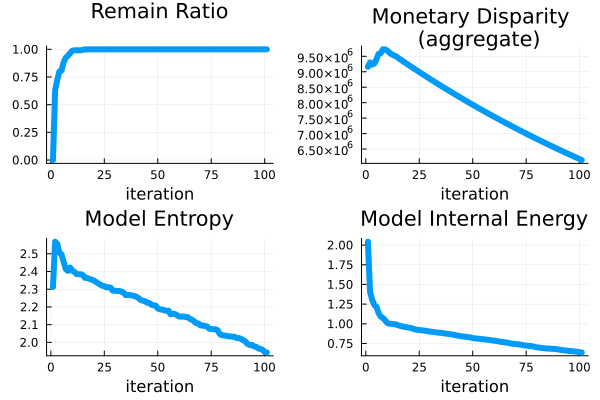

In [20]:
p1 = Plots.plot( model_df[!,:ModelRemainTrajectory], linewidth=6, legend=false, 
            title="Remain Ratio", xlabel="iteration" )
p2 = Plots.plot( model_df[!,:ModelFinancialDisparity], linewidth=6, legend=false,
            title="Monetary Disparity \n (aggregate)", xlabel="iteration" )
p3 = Plots.plot( model_df[!,:ModelEntropy], linewidth=6, legend=false,
            title="Model Entropy", xlabel="iteration" )
p4 = Plots.plot( model_df[!,:ModelInternalEnergy], linewidth=6, legend=false,
            title="Model Internal Energy", xlabel="iteration" )

pOveral = Plots.plot([p1,p2,p3,p4]..., layout=grid(2,2) )
savefig(pOveral,"./plots/pOverall.pdf")
display(pOveral)

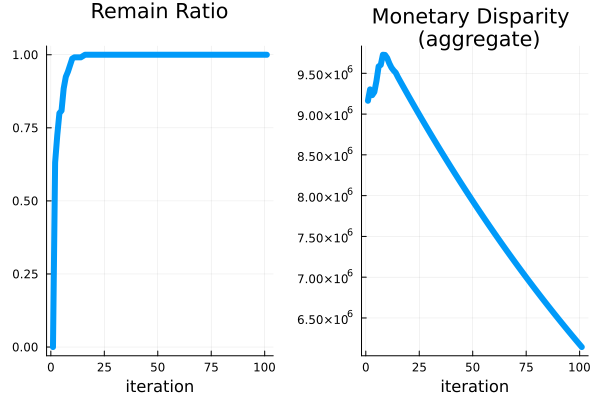

In [21]:
p1 = Plots.plot( model_df[!,:ModelRemainTrajectory], linewidth=6, legend=false, 
            title="Remain Ratio", xlabel="iteration" )
p2 = Plots.plot( model_df[!,:ModelFinancialDisparity], linewidth=6, legend=false,
            title="Monetary Disparity \n (aggregate)", xlabel="iteration" )

pOveral = Plots.plot([p1,p2]..., layout=grid(1,2) )
savefig(pOveral,"./plots/pRemainDisparity.pdf")
display(pOveral)

In [22]:
using QuadGK
using ForwardDiff

In [23]:
exp_fit = 0
lambda = 0
gamma_fit = 0

function pdf_exp_fit(x)
    
    pdf(exp_fit, x)
end

function Hist_Derivative(energy)
    return ForwardDiff.derivative( pdf_exp_fit , energy )
    #return f_prime
end

function Height_FN(energy)
    Hist_Derivative(energy) * log( pdf_exp_fit(energy) ) 
    #f_prime(energy) * log( pdf_exp_fit(energy) ) 
end

Height_FN (generic function with 1 method)

In [24]:
function f_prime(x)
    
    return -(lambda^2) * exp(-lambda * x)
    
end

f_prime (generic function with 1 method)

In [25]:
Tenergies = []

for STEP_NUM in 1:maximum( agent_df.step )
    step_tmp = filter(row -> row.step == STEP_NUM, agent_df);

    energies = []
    for row in eachrow( step_tmp )
        energy_tmp = row.potential_energy + row.kinetic_energy
        push!(energies,energy_tmp)
    end

    m_low = minimum(energies)
    m_high = maximum(energies)
    step_size = (m_high - m_low) / length(energies)
    energy_bins = m_low:step_size:m_high

    energy_hist = fit(Histogram, energies, energy_bins)
    energy_weights = energy_hist.weights
    nonzero_weights = filter(!iszero, energy_weights)
    energy_probabilities = nonzero_weights ./ sum(nonzero_weights)

    #global gamma_fit = fit(Gamma, energy_probabilities)
    global exp_fit = fit(Exponential, energy_probabilities)
    global lambda = exp_fit.θ

    integral_value, error_estimate = quadgk( Height_FN , m_low, m_high )

    T = (1/integral_value) #1.38*10^-23 * (1/integral_value)

    push!(Tenergies,T)
end

Tenergies

100-element Vector{Any}:
  -1.082587598084361
   9.908679203277593
 101.08509543962504
  -0.1798796189266923
  -0.14863078673785368
   1.6896146229832112
  -0.00249634723982758
  -0.0021252745581555725
  -0.0021651129710754356
  -0.0020290349587160817
  -0.0019580962418072516
  -0.0020278586121041343
  -0.0019915102391067844
   ⋮
  -0.0019039864836903255
  -0.001903601161435742
  -0.0019032178464084332
  -0.0019028365277505021
  -0.0019024571946668028
  -0.0019020798364245437
  -0.0019017044423528821
  -0.0019013310018425329
  -0.0019009595043453736
  -0.0019005899393740528
  -0.0019002222965016017
  -0.0018998565653610504

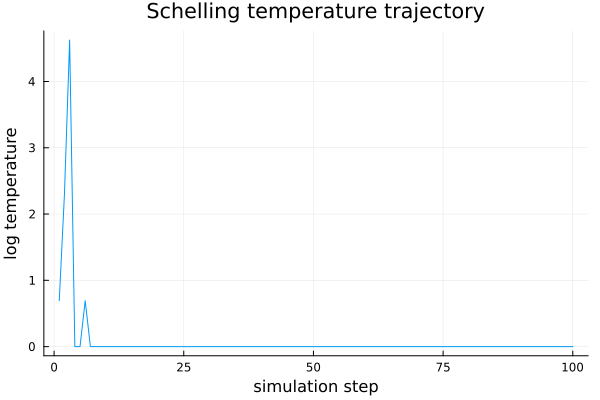

In [26]:
Plots.plot(  log.(ceil.(abs.(Tenergies)))
                    ,title="Schelling temperature trajectory", xlab="simulation step", ylab="log temperature", legend=false)

In [27]:
# G(p,T)= H-TS = U+pV-TS

In [28]:
x = 0:0.01:0.15
y1 = pdf.(gamma_fit,x)
y2 = pdf.(exp_fit,x)
p1 = histogram(energy_probabilities, normed=true)
Plots.plot!(x,y1,linewidth=5, title="gamma")
p2 = histogram(energy_probabilities, normed=true)
Plots.plot!(x,y2,linewidth=5, title="exponential")
Plots.plot(p1,p2)

LoadError: MethodError: no method matching pdf(::Int64, ::Float64)
[0mClosest candidates are:
[0m  pdf([91m::Beta[39m, ::Real) at ~/.julia/packages/Distributions/Ufrz2/src/univariates.jl:634
[0m  pdf([91m::NoncentralChisq[39m, ::Real) at ~/.julia/packages/Distributions/Ufrz2/src/univariates.jl:634
[0m  pdf([91m::InverseGaussian{T}[39m, ::Real) where T<:Real at ~/.julia/packages/Distributions/Ufrz2/src/univariate/continuous/inversegaussian.jl:79
[0m  ...